In [36]:
import torch
import torch.nn as nn
import torchvision.datasets as dsets
import torchvision.transforms as transforms
import torch.nn.init
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
# colab으로 visdom사용하는 법을 알아내지 못해 실행은 못했습니다.
import visdom

vis = visdom.Visdom()
vis.close(env="main")

In [38]:
# define loss_tracker
def loss_tracker(loss_plot, loss_value, num):
    '''num, loss_value, are Tensor'''
    plt.plot(X=num, Y=loss_value, win = loss_plot, update='append')

In [39]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

torch.manual_seed(777)
if device =='cuda':
    torch.cuda.manual_seed_all(777)

In [40]:
# parameters
learning_rate = 0.001
training_epochs = 15
batch_size = 32

In [41]:
mnist_train = dsets.MNIST(root='MNIST_data/', train = True, transform=transforms.ToTensor(), download=True)
mnist_test = dsets.MNIST(root='MNIST_data/', train=False, transform = transforms.ToTensor(), download=True)

data_loader = torch.utils.data.DataLoader(dataset=mnist_train, batch_size = batch_size, shuffle =True, drop_last=True)

In [42]:
# model
class CNN(nn.Module):
    
    def __init__(self):
        super(CNN, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(1,32,kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        
        self.layer2 = nn.Sequential(
            nn.Conv2d(32,64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        
        self.layer3 = nn.Sequential(
            nn.Conv2d(64,128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        
        self.fc1 = nn.Linear(3*3*128, 625)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(625, 10, bias =True)
        torch.nn.init.xavier_uniform_(self.fc1.weight)
        torch.nn.init.xavier_uniform_(self.fc2.weight)
    
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        
        out = out.view(out.size(0), -1)
        out = self.fc1(out)
        out = self.relu(out)
        out = self.fc2(out)
        return out  

In [43]:
model = CNN().to(device)
value = (torch.Tensor(1,1,28,28)).to(device)
print( (model(value)).shape ) 

torch.Size([1, 10])


In [44]:
criterion = nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)

In [26]:
!pip install tensorboardcolab
from tensorboardcolab import TensorBoardColab
tb = TensorBoardColab()

  Created wheel for tensorboardcolab: filename=tensorboardcolab-0.0.22-py3-none-any.whl size=3857 sha256=3c043f76bd388130948fac3b9db860f2b2296f2abcac1296a9a005f7ac795631
  Stored in directory: /root/.cache/pip/wheels/69/4e/4a/1c6c267395cb10edded1050df12af165d3254cfce324e80941
Successfully built tensorboardcolab
Wait for 8 seconds...
TensorBoard link:
http://e240-35-196-149-168.ngrok.io


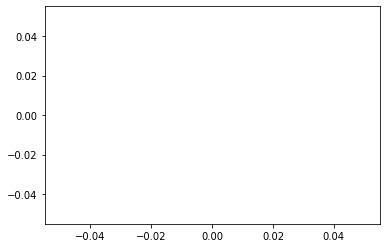

In [45]:
# colab으로 visdom사용하는 법을 알아내지 못해 실행은 못했습니다.
# plot
loss_plt = plt.plot(Y=torch.Tensor(1).zero_(),opts=dict(title='loss_tracker', legend=['loss'], showlegend=True))

[Epoch:1] cost = 0.12822940945625305
[Epoch:2] cost = 0.042089905589818954
[Epoch:3] cost = 0.02942848578095436
[Epoch:4] cost = 0.02268327958881855
[Epoch:5] cost = 0.0169739481061697
[Epoch:6] cost = 0.01452028751373291
[Epoch:7] cost = 0.013654734939336777
[Epoch:8] cost = 0.010637011379003525
[Epoch:9] cost = 0.009515712037682533
[Epoch:10] cost = 0.008690102957189083
[Epoch:11] cost = 0.008712569251656532
[Epoch:12] cost = 0.007471923716366291
[Epoch:13] cost = 0.007302897982299328
[Epoch:14] cost = 0.006870930083096027
[Epoch:15] cost = 0.0054826256819069386
Learning Finished!


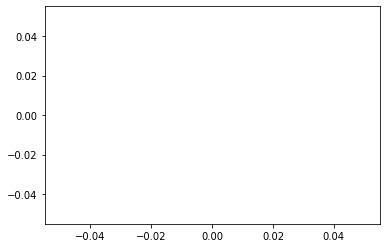

In [46]:
# train
total_batch = len(data_loader)

for epoch in range(training_epochs):
    avg_cost = 0
    
    for X, Y in data_loader:
        X = X.to(device)
        Y = Y.to(device)
        
        optimizer.zero_grad()
        hypothesis = model(X)
        
        cost = criterion(hypothesis, Y)
        cost.backward()
        optimizer.step()
        
        avg_cost += cost / total_batch
    
    print('[Epoch:{}] cost = {}'.format(epoch+1, avg_cost))
    loss_tracker(loss_plt, torch.Tensor([avg_cost]), torch.Tensor([epoch]))
print('Learning Finished!')

In [47]:
# test
with torch.no_grad():
    X_test = mnist_test.test_data.view(len(mnist_test), 1, 28, 28).float().to(device)
    Y_test = mnist_test.test_labels.to(device)
    
    prediction = model(X_test)
    correct_prediction = torch.argmax(prediction, 1) == Y_test
    accuracy = correct_prediction.float().mean() 
    print('Accuracy:', accuracy.item())

/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:67: UserWarning: test_data has been renamed data
  warnings.warn("test_data has been renamed data")
/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:57: UserWarning: test_labels has been renamed targets
  warnings.warn("test_labels has been renamed targets")


Accuracy: 0.9847999811172485
